1. Pick size of block and size of overlap
2. synthesize blocks in raster order
3. search input texture for block that satisfies overlap constraints(above and left)
   - eash to optimize using nn search
4. paste new block into resulting texture
   - use dynamic programming to compute minimal error boundary cut

In [5]:
%matplotlib inline

from matplotlib import image
from matplotlib import pyplot as plt
import numpy as np
import numpy.matlib
import cv2
from skimage import io
import sys
from scipy import ndimage, signal
from random import randint, gauss
import math
from skimage.color import rgba2rgb, rgb2gray
import time

np.set_printoptions(threshold=sys.maxsize)

<Figure size 432x288 with 0 Axes>

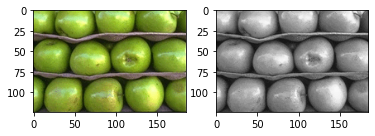

In [8]:
apples = image.imread('../images/apples.png')
a = rgba2rgb(apples)
inputTexture = rgb2gray(a)   
[m, n] = inputTexture.shape

plt.figure()
fig, arr = plt.subplots(1,2) 

arr[0].imshow(a)
arr[1].imshow(inputTexture, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)

In [7]:
if (a.shape[2] != 3):
    a = numpy.repeat(a[:, :, np.newaxis], 3, axis=2)
a.shape

(124, 185, 3)

In [9]:
magnification = 3;
w = 50;
o = round(w/3);
m1 = math.ceil(m*magnification/w)*w+o
n1 = math.ceil(n*magnification/w)*w+o
outputTexture = np.zeros([m1,n1])
outputTexture1 = np.zeros([m1,n1,3])

In [10]:
def givePatch(a,inputTexture,temp1,mask):
    temp2 = np.linalg.multi_dot([temp1,temp1,mask])
    temp3 = np.multiply(inputTexture, inputTexture)
    temp3 = signal.convolve2d(temp3, np.rot90(mask, 2), mode='valid')
    temp4 = signal.convolve2d(inputTexture, np.rot90(np.multiply(temp1, mask), 2), mode='valid')
    errors = np.sum(temp2.reshape(-1, 1))+temp3-2*temp4
    minerror = abs(np.min(errors.reshape(-1, 1)))
    [x,y] = np.where(errors <= minerror*1.1)
    rand_int = randint(0, len(x))
    [m,n] = mask.shape;
    nearPatch = inputTexture[x[rand_int]:x[rand_int]+m,y[rand_int]:y[rand_int]+n]
    nearPatch1 = a[x[rand_int]:x[rand_int]+m,y[rand_int]:y[rand_int]+n,:]
    return nearPatch, nearPatch1

In [11]:
def findBoundaryHelper1(error):
    x, y = error.shape[0], error.shape[1] 
    path = np.zeros([x, y])
    cost = np.zeros([x, y])
    cost[x-1,:] = error[x-1,:]
    for i in range(x-2, 0, -1):
        mintree = np.array([np.append(float('+inf'), cost[i,0:y-1]), cost[i,:], np.append(cost[i,1:y], float('+inf'))], dtype=object)
        + error[i-1,:] 
        cost[i,:] = np.min(mintree, axis = 0)
        path[i,:] = np.argmin(mintree, axis=0)
    np.where(path==1, path, 0)
    np.where(path==0, path, -1)
    np.where(path==2, path, 1)
    return cost, path

In [12]:
def findBoundaryHelper2(path, ind):
    m = path.shape[1]
    boundary = np.zeros([path.shape[0], path.shape[1]])
    boundary[0,0:ind] = 1
    prev = ind - 1
    for i in range(1, m-1):
        prev = prev + path[i, int(prev)]
        boundary[i, 0:int(prev)] = 1
    return boundary

In [ ]:
for i in range(0, math.floor(m1/w)):
    for j in range(0, math.floor(n1/w)):
        mask = np.zeros([w+o,w+o]);
        temp1 = outputTexture[i*w:(i+1)*w+o,j*w:(j+1)*w+o] 
        if(i==0 and j == 0):
            outputTexture[0:w+o,0:w+o] = inputTexture[0:w+o,0:w+o]
            outputTexture1[0:w+o,0:w+o,:] = a[0:w+o,0:w+o,:]
            continue
        elif(i==0):
            mask[:,0:o] = 1

            [nearPatch, nearPatch1] = givePatch(a,inputTexture,temp1,mask)
            error = np.power((np.multiply(nearPatch, mask) - np.multiply(temp1, mask)), 2)
            error = error[:,0:o]

            [cost,path] = findBoundaryHelper1(error)
            boundary = np.zeros([w+o, w+o])
            ind = int(np.argmin(cost[0,:]))
            boundary[:,0:o] = findBoundaryHelper2(path, ind)

        elif(j==0):
            mask[0:o,:] = 1
            
            [nearPatch,nearPatch1] = givePatch(a,inputTexture,temp1,mask)
            error = np.power((np.multiply(nearPatch, mask) - np.multiply(temp1, mask)), 2)
            error = error[0:o,:]
            [cost,path] = findBoundaryHelper1(error.T)
            boundary = np.zeros([w+o,w+o])
            ind = int(np.argmin(cost[0,:]))
            boundary[0:o,:] = (findBoundaryHelper2(path,ind)).T
        else:
            mask[:,0:o] = 1;
            mask[0:o,:] = 1;
            
            [nearPatch, nearPatch1] = givePatch(a,inputTexture,temp1,mask)

            error = np.power((np.multiply(nearPatch, mask) - np.multiply(temp1, mask)), 2)
            error1 = error[0:o,:]

            [cost1,path1] = findBoundaryHelper1(error1.T)
            
            error2 = error[:,0:o]

            [cost2,path2] = findBoundaryHelper1(error2)
            
            cost = np.add(cost1[0:o,:], cost2[0:o,:])
            boundary =  np.zeros([w+o,w+o])
    
            ind = int(np.argmin(np.diag(cost)))
            boundary[0:o,ind:w+o] = (findBoundaryHelper2(path1[ind:o+w,:],o-ind)).T
            
            boundary[ind:o+w,0:o] = findBoundaryHelper2(path2[ind:o+w,:], ind)
            
            boundary[0:ind,0:ind] = 1
        smoothBoundary = boundary
        smoothBoundary1 = numpy.repeat(boundary[:, :, np.newaxis], 3, axis=2)
        temp2 = np.multiply(temp1, smoothBoundary) + np.multiply(nearPatch, (1-smoothBoundary))
        outputTexture[i*w:(i+1)*w+o,j*w:(j+1)*w+o] = temp2
        outputTexture1[i*w:(i+1)*w+o,j*w:(j+1)*w+o,:] = np.multiply(outputTexture1[i*w:(i+1)*w+o, j*w:(j+1)*w+o,:], smoothBoundary1) + np.multiply(nearPatch1, (1-smoothBoundary1))
output = outputTexture1[0:m1-o,0:n1-o,:]
plt.imshow(output)